In [1]:
import numpy as np
from matplotlib import pyplot as plt


plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

import kwant
kwant.__version__

/Users/nagydaniel/miniconda3/lib/python3.6/site-packages/kwant/solvers/default.py:18: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  "Performance can be very poor in this case.", RuntimeWarning)


'1.4.1'

In [2]:
s0 = np.array([[1, 0], [0, 1]])
sx = np.array([[0, 1], [1, 0]])
sy = np.array([[0, -1j], [1j, 0]])
sz = np.array([[1, 0], [0, -1]])

# Simple square lattice

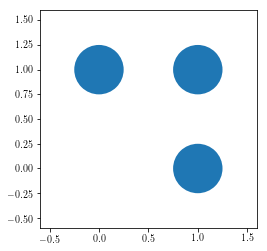

In [3]:
a = 1
lat = kwant.lattice.square(a)
syst = kwant.Builder()

syst[lat(1, 0)] = 2
syst[lat(0, 1)] = 4
syst[lat(1, 1)] = 5

kwant.plot(syst);

# Two monatomic lattices

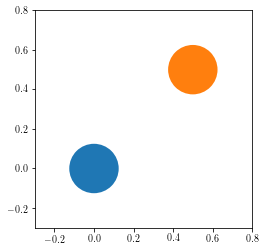

In [4]:
primitive_vectors = [(1, 0), (0, 1)]
lat_a = kwant.lattice.Monatomic(primitive_vectors, offset=(0, 0))
lat_b = kwant.lattice.Monatomic(primitive_vectors, offset=(0.5, 0.5))

# lat1 is equivalent to kwant.lattice.square()
syst = kwant.Builder()

# Onsite matrix elements can be even matrices:
syst[lat_a(0, 0)] = 4*sx
syst[lat_b(0, 0)] = 4*sy + 3*sy.conj().T

kwant.plot(syst);

# One polyatomic lattice containing two sublattices

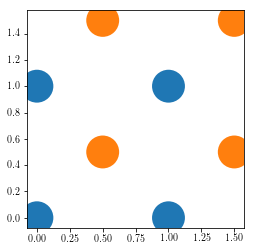

In [5]:
# https://kwant-project.org/doc/1/reference/generated/kwant.lattice.Polyatomic#kwant.lattice.Polyatomic
lat = kwant.lattice.Polyatomic(prim_vecs=[(1, 0), (0, 1)], # The primitive vectors of the Bravais lattice
                               basis=[(0, 0), (0.5, 0.5)]) # The coordinates of the basis sites inside the unit cell.

sub_a, sub_b = lat.sublattices

syst = kwant.Builder()

syst[sub_a(1,1)] = 4
syst[sub_a(0,0)] = 4
syst[sub_a(1,0)] = 4
syst[sub_a(0,1)] = 4

syst[sub_b(0,0)] = 4
syst[sub_b(0,1)] = 4
syst[sub_b(1,0)] = 4
syst[sub_b(1,1)] = 4

kwant.plot(syst);

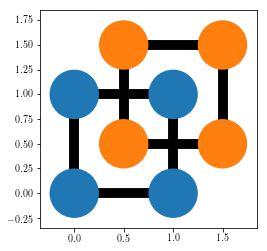

In [6]:
syst[sub_a.neighbors()] = -1
syst[sub_b.neighbors()] = -1

kwant.plot(syst);

# 1 dimensional lattice

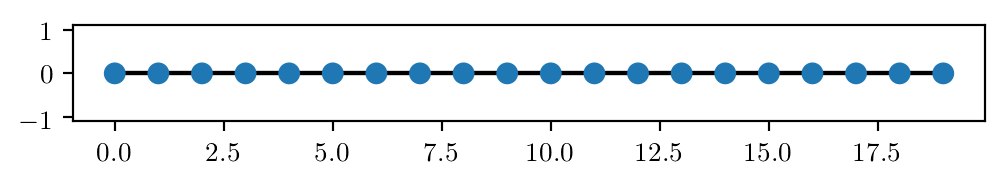

In [7]:
def create_chain(a=1, n=20, hoppings=False):
  lat = kwant.lattice.chain(a)
  
  syst = kwant.Builder()
  
  for j in range(20):
    syst[lat(j)] = 4
    
  if hoppings:
    syst[lat.neighbors()] = -1
  
  return lat, syst

lat, sys = create_chain(1,20, True)
kwant.plot(sys, dpi=196);

# Solving eigenvalues for a closed system

In [8]:
# Get the hamiltonian matrix of the system
ham_mat = syst.finalized().hamiltonian_submatrix(sparse=True)

# Use scipy to solve the eigenvalue problem
import scipy.sparse.linalg as sla

# The 15 lowest eigenvalues
ev = sla.eigsh(ham_mat.tocsc(), k=5, return_eigenvectors=False)

In [9]:
ev

array([4., 4., 4., 6., 6.])

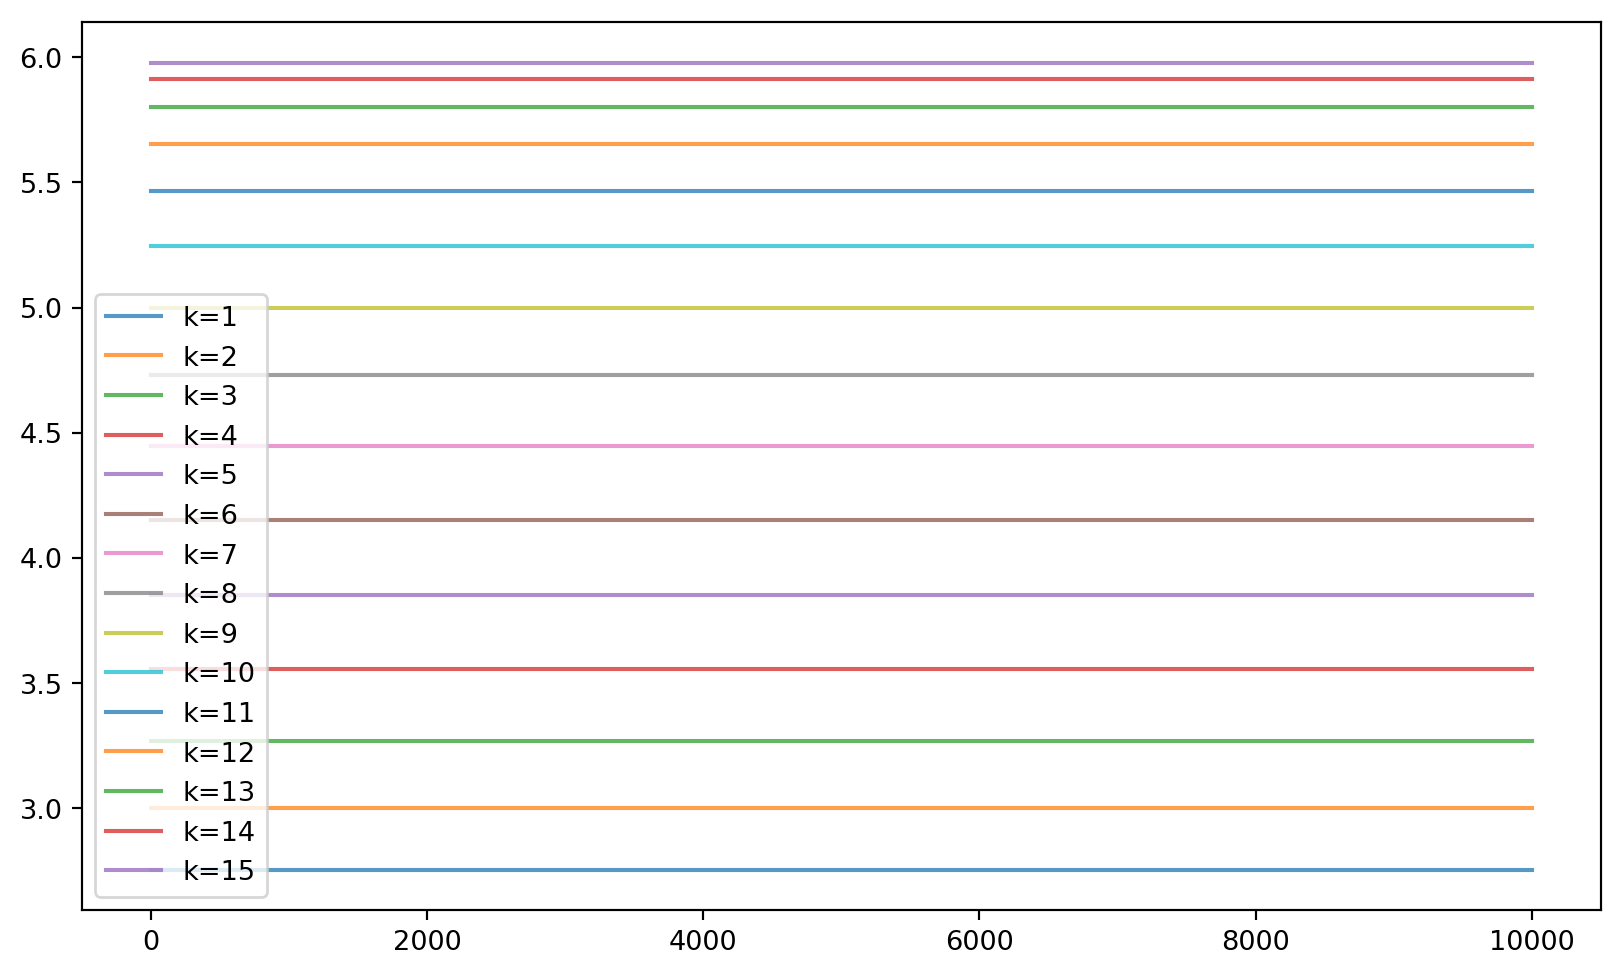

In [10]:
# Use scipy to solve the eigenvalue problem
import scipy.sparse.linalg as sla

def eigv_plotter():
  
  aa = np.linspace(0.01, 10000, 1000)
  evs = []
  
  n_eig = 15 # The number of lowest eigenvalues
  
  for a in aa:
    lat, sys = create_chain(a, 2, True)
    ham_mat = sys.finalized().hamiltonian_submatrix(sparse=True)
    
    
    ev = sla.eigsh(ham_mat.tocsc(), k=n_eig, return_eigenvectors=False)
    evs.append(ev)
    
  evs = np.array(evs)
  
  plt.figure(figsize=(10, 6), dpi=196)
  
  for j in range(n_eig):
    plt.plot(aa, evs.T[j, :], '-', alpha=.75, label="k={}".format(j+1))
    
  plt.legend()
  
  
eigv_plotter()

# Attaching leads to a system

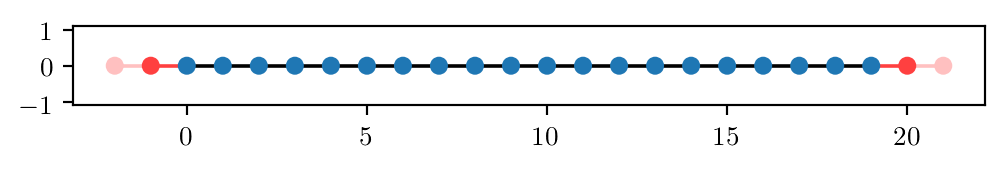

In [10]:
# Left lead
sleft = kwant.TranslationalSymmetry((-1,))
left_lead = kwant.Builder(sleft)

for j in range(5):
  left_lead[lat(j)] = 4

left_lead[lat.neighbors()] = -1
sys.attach_lead(left_lead)

# Right lead
sright = kwant.TranslationalSymmetry((1,))
right_lead = kwant.Builder(sright)

for j in range(5):
  right_lead[lat(20+j)] = 4
  
right_lead[lat.neighbors()] = -1
sys.attach_lead(right_lead)

kwant.plot(sys, dpi=196);

# Creating a square lattice with circle shape

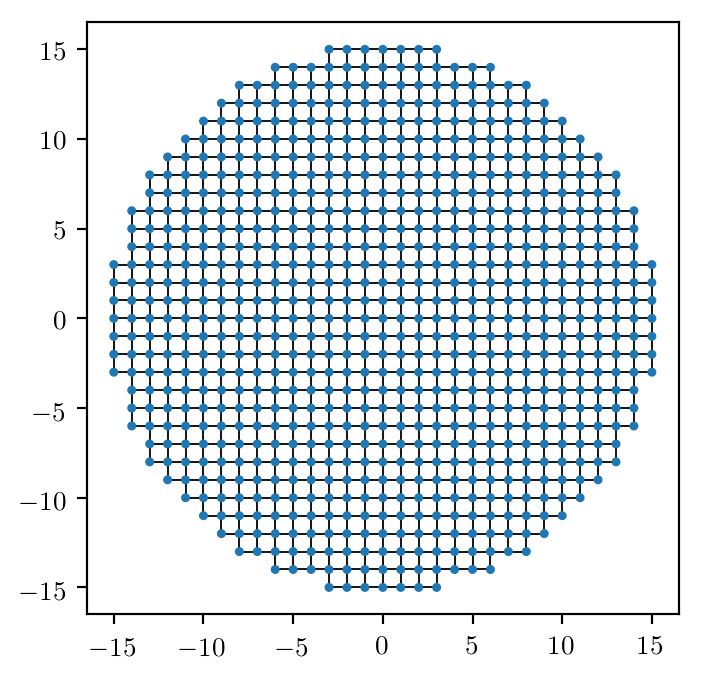

In [11]:
a = 1
lat = kwant.lattice.square(a)
syst = kwant.Builder()

# A shape can be defined using a function, that returns True, if a point is
# inside the shape, False otherwise
def circle(pos):
  x,y = pos
  return x**2 + y**2 < 240

t = -1

# Doc: https://kwant-project.org/doc/1/reference/generated/kwant.lattice.Polyatomic#kwant.lattice.Polyatomic.shape
syst[lat.shape(function=circle, start=(0,0))] = -4*t

# Adding hoppings to the lattice:
syst[lat.neighbors()] = t

fig = kwant.plot(syst, dpi=196);
fig.savefig("circular_square_lat.png", dpi=196)

/Users/nagydaniel/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: The plotted data contains 1.15% of values overflowing upper limit 0.0088008 
  # This is added back by InteractiveShellApp.init_path()
/Users/nagydaniel/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: The plotted data contains 1.02% of values overflowing upper limit 0.00781266 
  # This is added back by InteractiveShellApp.init_path()


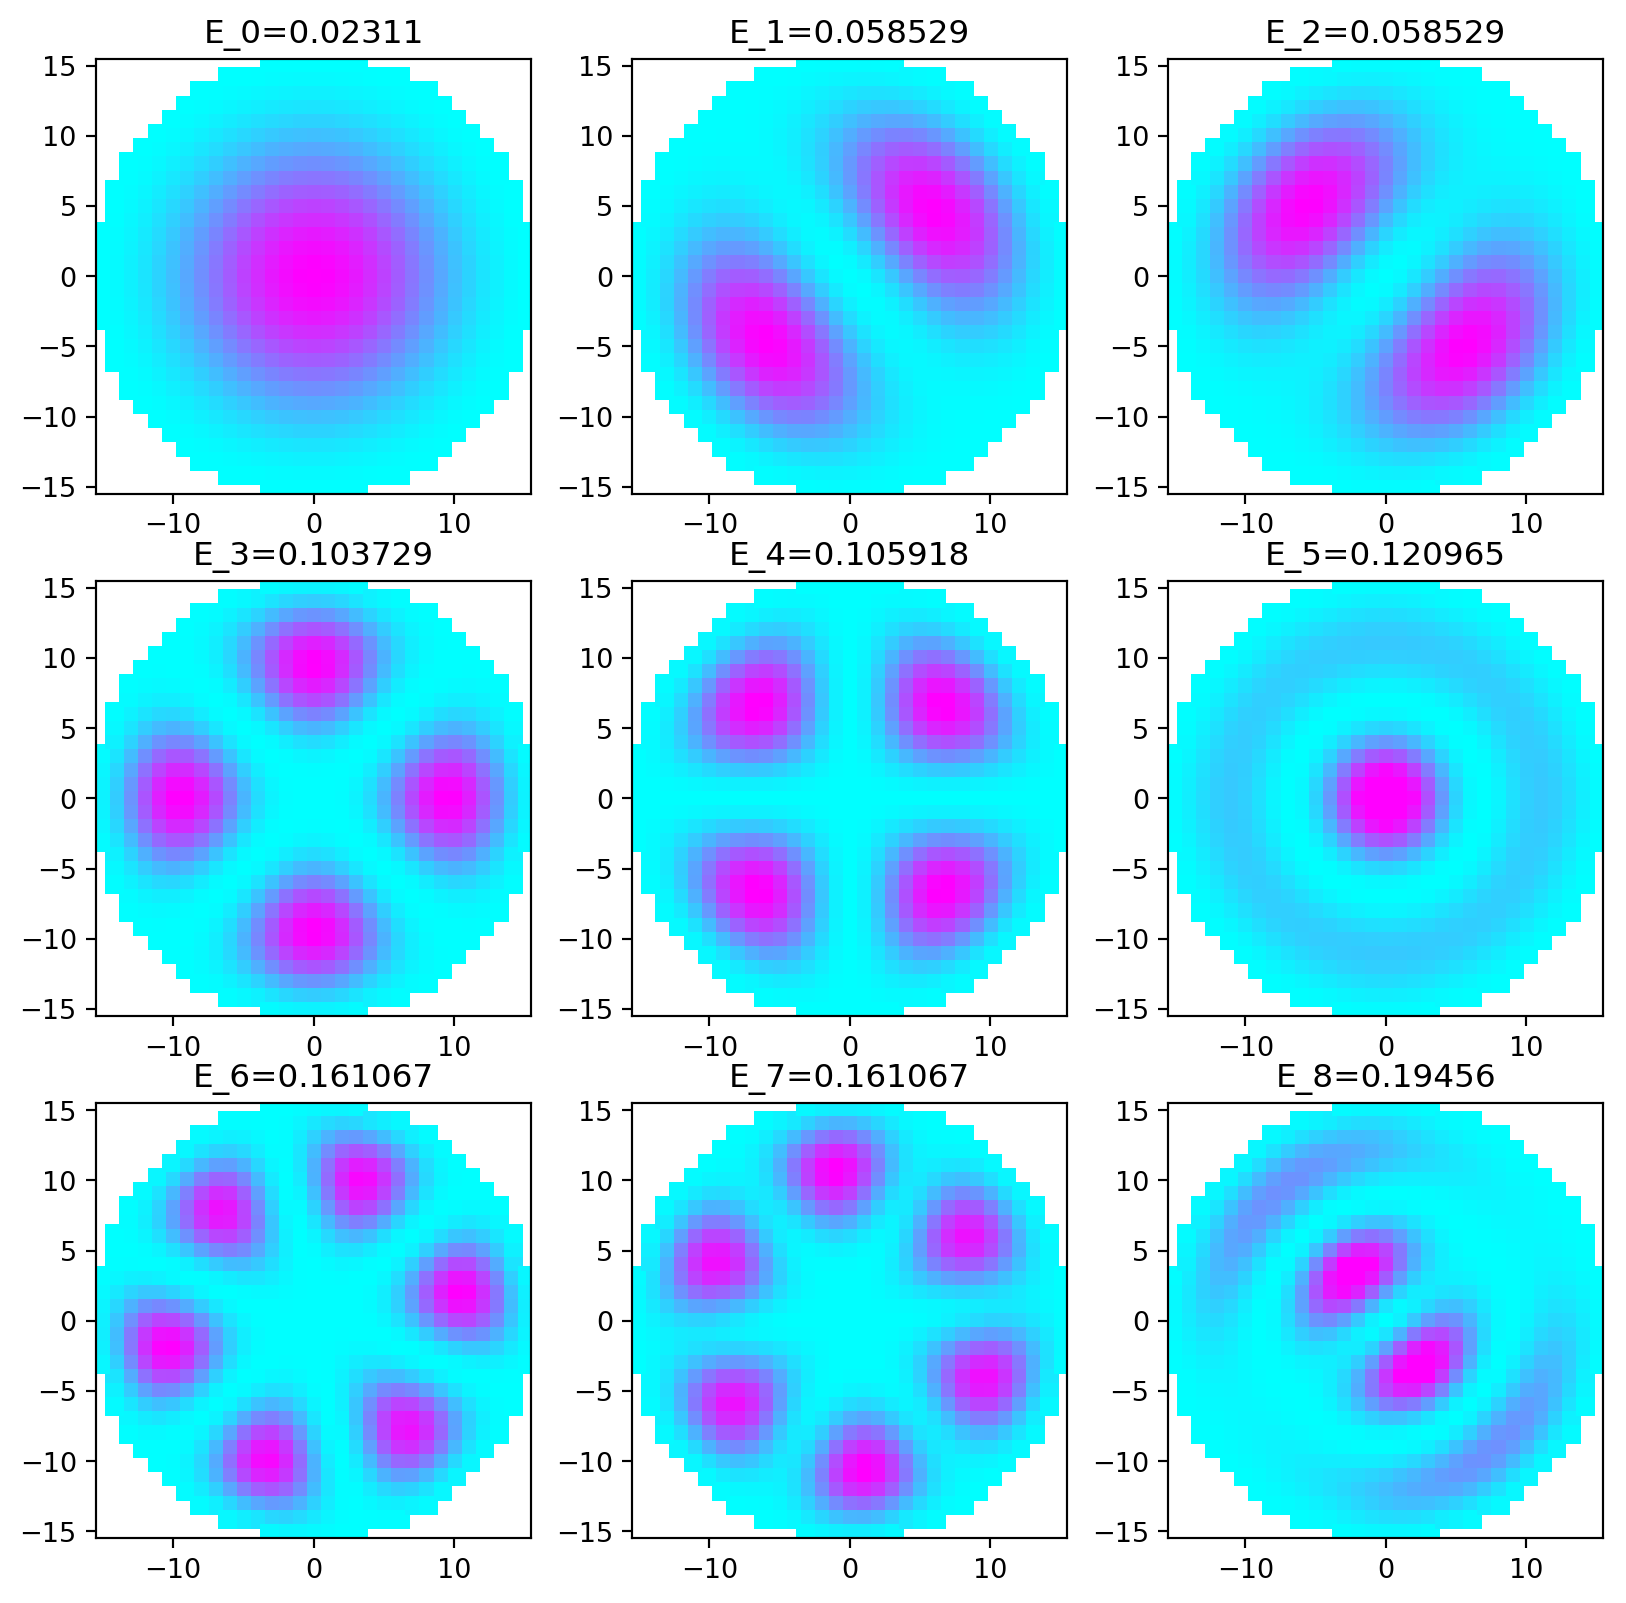

In [13]:
# Calculate wavefunctions and plot 
ham_mat = syst.finalized().hamiltonian_submatrix(sparse=True)
evals, evecs = sla.eigsh(ham_mat.tocsc(), k=9, sigma=0)

fig, axes = plt.subplots(3, 3, figsize=(10, 10), dpi=196)

for i in range(9):
  kwant.plotter.map(syst.finalized(), 
                    np.abs(evecs[:, i])**2, 
                    cmap='cool', background='w',
                    ax=axes[int(i/3)][i%3])
  axes[int(i/3)][i%3].set_title("E_{0}={1}".format(i, np.round(evals[i],6)))
  
fig.savefig("circular_square_lat_eigvs.png", dpi=196)

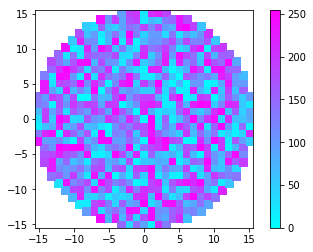

In [14]:
kwant.plotter.map(syst.finalized(), np.random.randint(0,255, size=(749,)), cmap='cool', background='w');

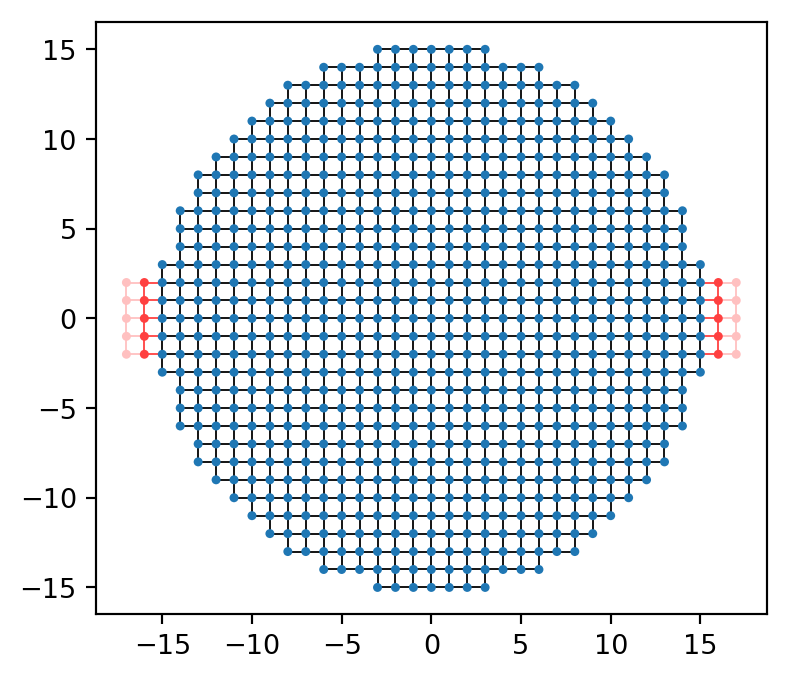

In [15]:
lead_W = 6.0

def lead_shape(pos):
  x,y = pos
  return (-lead_W/2 < y < lead_W/2)

lead_sym = kwant.TranslationalSymmetry((-a, 0))
lead = kwant.Builder(lead_sym)

lead[lat.shape(lead_shape, (0,0))] = 4
lead[lat.neighbors()] = -1

syst.attach_lead(lead)
syst.attach_lead(lead.reversed())

fig = kwant.plot(syst, dpi=196);
fig.savefig("circular_sq_lat_wleads.png", dpi=196)

# Calculating local density of states

/Users/nagydaniel/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: The plotted data contains 1.02% of values overflowing upper limit 0.0773557 
  


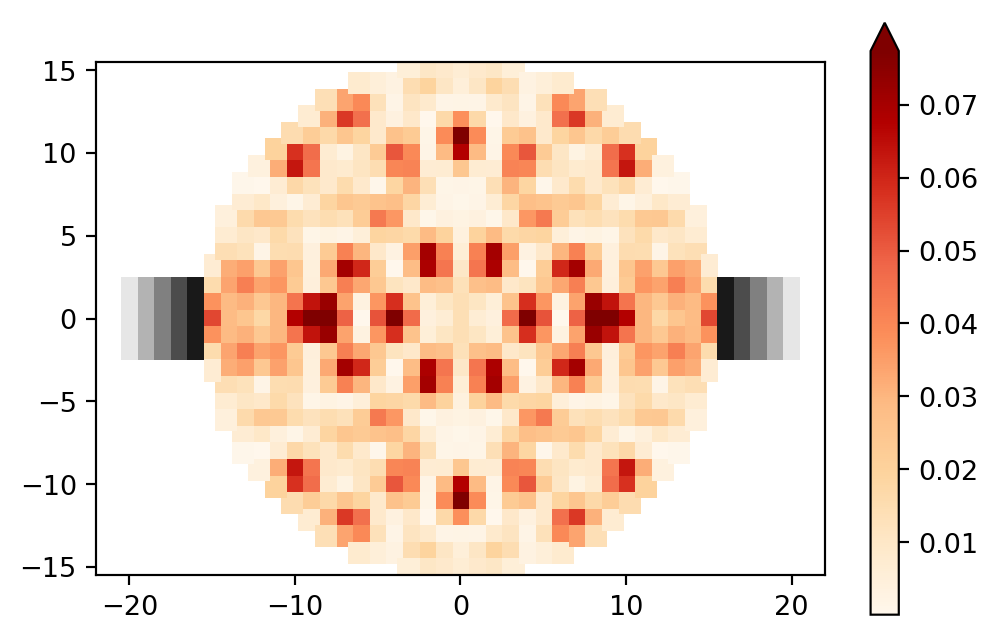

In [16]:
local_dos = kwant.ldos(syst.finalized(), energy=1.0)
fig = kwant.plotter.map(syst.finalized(), local_dos, 
                  num_lead_cells=5,
                  background='w',
                  cmap='OrRd',
                  dpi=196);
fig.savefig("circular_square_lat_ldos.png", dpi=196)

# Point contact (constriction)

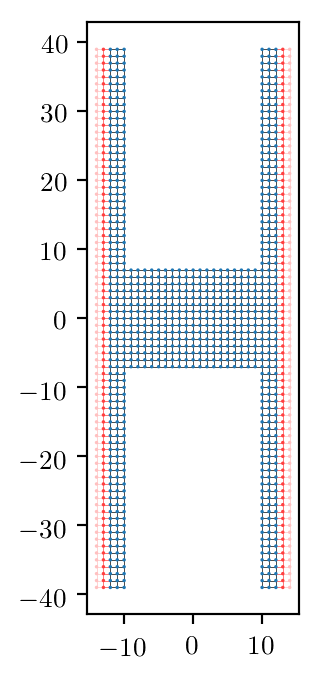

In [12]:
a = 1
lat = kwant.lattice.square(a)
syst = kwant.Builder()

t = -2.0
V_L = -3*t
V_S = -3*t

w_constriction = 8
l_constriction = 10

w_lead = 40
l_lead = 3

# A shape can be defined using a function, that returns True, if a point is
# inside the shape, False otherwise
def shape1(pos):
  x,y = pos
  return abs(x) < l_constriction and abs(y) < w_constriction

def shape2(pos):
  x,y = pos
  return (l_constriction <= abs(x) < l_constriction + l_lead) and abs(y) < w_lead 

# Doc: https://kwant-project.org/doc/1/reference/generated/kwant.lattice.Polyatomic#kwant.lattice.Polyatomic.shape
syst[lat.shape(function=shape1, start=(0,0))] = V_S
syst[lat.shape(function=shape2, start=(l_constriction,0))] = V_S
syst[lat.shape(function=shape2, start=(-l_constriction,0))] = V_S

# Adding hoppings to the lattice:
syst[lat.neighbors()] = t

# Attach leads to the system
def lead_shape(pos):
  x,y = pos
  return (-w_lead < y < w_lead)

lead_sym = kwant.TranslationalSymmetry((-a, 0))
lead = kwant.Builder(lead_sym)

lead[lat.shape(lead_shape, (0,0))] = V_L
lead[lat.neighbors()] = t

syst.attach_lead(lead)
syst.attach_lead(lead.reversed())

fig = kwant.plot(syst, dpi=196);
fig.savefig("2degconst_W{0}_L{1}.png".format(w_constriction, l_constriction), dpi=196)

In [13]:
energies = np.linspace(0, 5, 150)
data = []

syst = syst.finalized()

sn_data = []

for e in energies:
  # compute the scattering matrix at a given energy
  smatrix = kwant.smatrix(syst, e)
  
  # compute the transmission probability from lead 0 to
  # lead 1
  data.append(smatrix.transmission(1, 0))
  
  # Calculating two-terminal shotnoise for the same system
  sn_data.append(kwant.physics.two_terminal_shotnoise(smatrix))

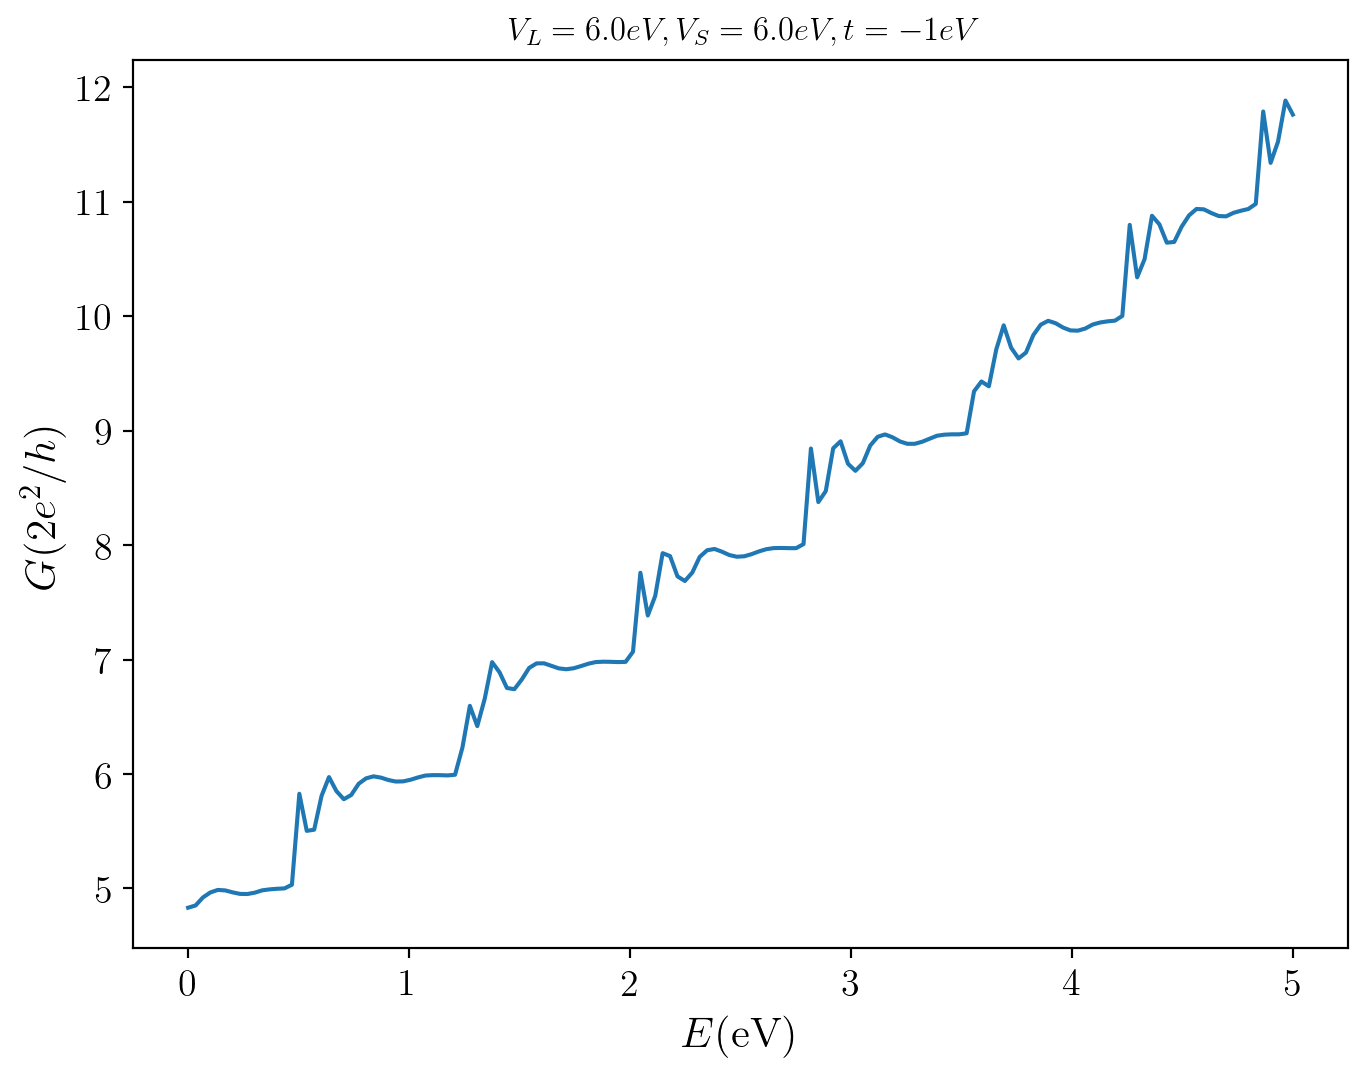

In [28]:
# We should see conductance steps
plt.figure(figsize=(8,6), dpi=196)
plt.plot(energies, data, "-")
plt.title(r"$V_L={0} eV, V_S={1} eV, t={2} eV$".format(V_L, V_S, t))
plt.xlabel(r"$E (\textnormal{eV})$", fontsize=16)
plt.ylabel(r"$G (2e^2/h)$", fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.savefig("cond_2deg_W{0}_L{1}_VL{2}_VS{3}.png".format(w_constriction, l_constriction, V_L, V_S), dpi=196)

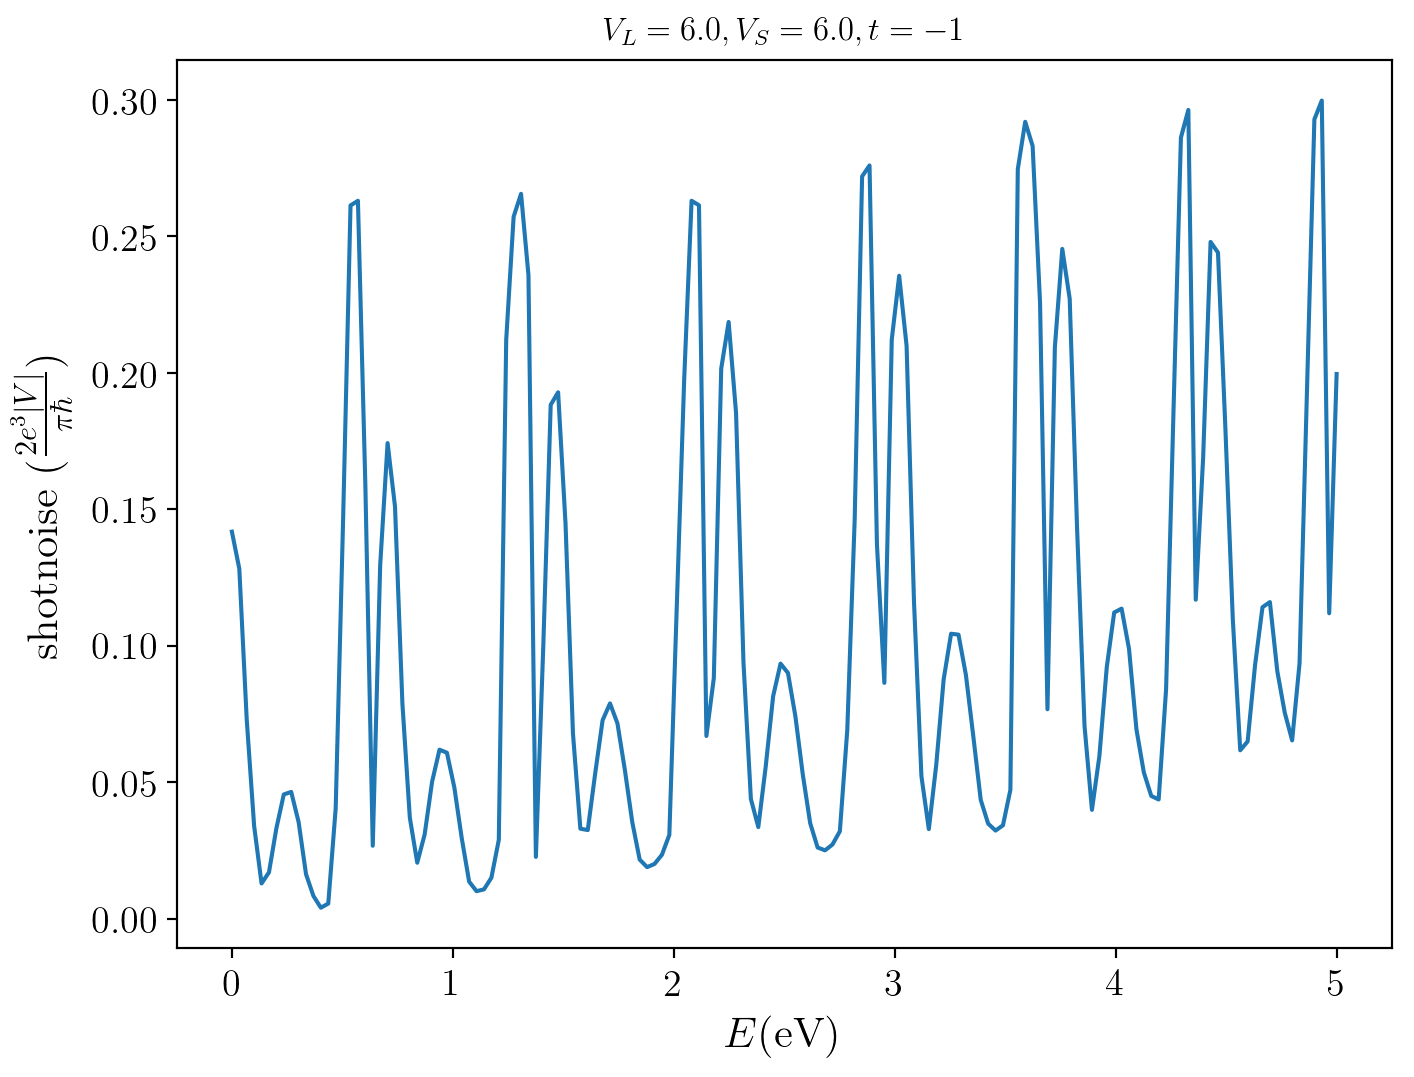

In [29]:
plt.figure(figsize=(8,6), dpi=196)
plt.plot(energies, sn_data, "-")

plt.title(r"$V_L={0} eV, V_S={1} eV, t={2} eV$".format(V_L, V_S, t))
plt.xlabel(r"$E (\textnormal{eV})$", fontsize=16)
plt.ylabel(r"shotnoise ($\frac{2e^3|V|}{\pi\hbar}$)", fontsize=16)
plt.title(r"$V_L={0}, V_S={1}, t={2}$".format(V_L, V_S, t))
plt.tick_params(axis='both', which='major', labelsize=14)
plt.savefig("shotnoise_2deg_W{0}_L{1}_VL{2}_VS{3}.png".format(w_constriction, l_constriction, V_L, V_S), dpi=196)

# Quantum point contact in magnetic field

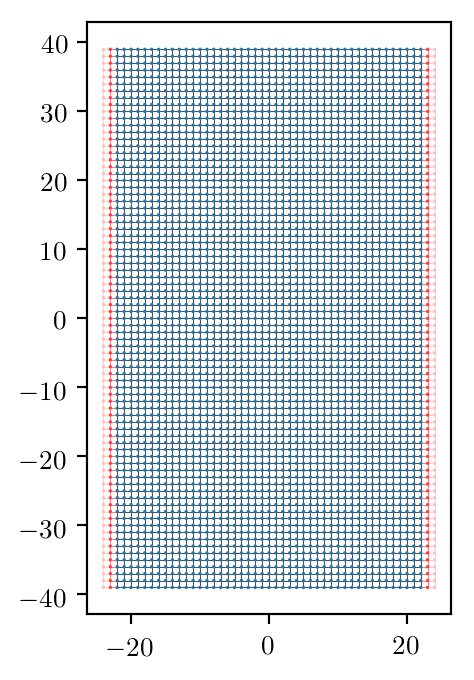

In [18]:
a = 1
lat = kwant.lattice.square(a)
syst = kwant.Builder()

w_constriction = 40
l_constriction = 20

w_lead = 40
l_lead = 3


t = -1
onsite = -4*t

# A shape can be defined using a function, that returns True, if a point is
# inside the shape, False otherwise
def shape1(pos):
  x,y = pos
  return abs(x) < l_constriction and abs(y) < w_constriction

def shape2(pos):
  x,y = pos
  return (l_constriction <= abs(x) < l_constriction + l_lead) and abs(y) < w_lead


# Doc: https://kwant-project.org/doc/1/reference/generated/kwant.lattice.Polyatomic#kwant.lattice.Polyatomic.shape
syst[lat.shape(function=shape1, start=(0,0))] = onsite
syst[lat.shape(function=shape2, start=(l_constriction,0))] = onsite
syst[lat.shape(function=shape2, start=(-l_constriction,0))] = onsite

# Hopping values in presence of magnetic field
# phi is the flux through a unit cell in the square lattice, measured in h/e flux quanta
def hopping(site_i, site_j, params):
    xi, yi = site_i.pos
    xj, yj = site_j.pos
    return -np.exp(-0.5j * params.phi * (xi - xj) * (yi + yj))

# Adding hoppings to the lattice:
syst[lat.neighbors()] = hopping

# Attach leads to the system
def lead_shape(pos):
  x,y = pos
  return (-w_lead < y < w_lead)

lead_sym = kwant.TranslationalSymmetry((-a, 0))
lead = kwant.Builder(lead_sym)

lead[lat.shape(lead_shape, (0,0))] = onsite
lead[lat.neighbors()] = t

syst.attach_lead(lead)
syst.attach_lead(lead.reversed())

fig = kwant.plot(syst, dpi=196);

In [19]:
from types import SimpleNamespace

energy = 0.2
phis = np.linspace(0, 0.2, 91)

fsyst = syst.finalized()

Gs = []
for phi in phis:
  params=SimpleNamespace(phi=phi)
  smat = kwant.smatrix(fsyst, energy=energy, args=[params])
  Gs.append(smat.transmission(1, 0))
  
plt.plot(phis, Gs);
plt.ylabel("G [G_0]")
plt.xlabel("phi")

/Users/nagydaniel/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: KwantDeprecationWarning: The 'args' parameter has been deprecated since version 1.4 -- Instead, provide named parameters as a dictionary via 'params'.
  # This is added back by InteractiveShellApp.init_path()
/Users/nagydaniel/miniconda3/lib/python3.6/site-packages/kwant/solvers/common.py:164: KwantDeprecationWarning: The 'args' parameter has been deprecated since version 1.4 -- Instead, provide named parameters as a dictionary via 'params'.
  params=params)[:2]
/Users/nagydaniel/miniconda3/lib/python3.6/site-packages/kwant/solvers/common.py:191: KwantDeprecationWarning: The 'args' parameter has been deprecated since version 1.4 -- Instead, provide named parameters as a dictionary via 'params'.
  prop, stab = lead.modes(energy, args, params=params)
/Users/nagydaniel/miniconda3/lib/python3.6/site-packages/kwant/system.py:305: KwantDeprecationWarning: The 'args' parameter has been deprecated since version 

Text(0.5, 0, 'phi')

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x10c452ae8> (for post_execute):


RuntimeError: latex was not able to process the following string:
b'G [G_0]'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.17 (TeX Live 2016) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/Users/nagydaniel/.matplotlib/tex.cache/e14333b77589c82ff2716f20835bca9a.tex
LaTeX2e <2016/03/31>
Babel <3.9r> and hyphenation patterns for 83 language(s) loaded.
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2016/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/textcomp.sty
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/inputenc.sty
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/utf8.def
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/t1enc.dfu)
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/ot1enc.dfu)
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/omsenc.dfu)
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/ts1enc.dfu)))
(/usr/local/texlive/2016/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2016/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2016/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/local/texlive/2016/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/local/texlive/2016/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

)
No file e14333b77589c82ff2716f20835bca9a.aux.
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.14 ...size{10.000000}{12.500000}{\rmfamily G [G_
                                                  0]}
No pages of output.
Transcript written on e14333b77589c82ff2716f20835bca9a.log.




RuntimeError: latex was not able to process the following string:
b'G [G_0]'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.17 (TeX Live 2016) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/Users/nagydaniel/.matplotlib/tex.cache/e14333b77589c82ff2716f20835bca9a.tex
LaTeX2e <2016/03/31>
Babel <3.9r> and hyphenation patterns for 83 language(s) loaded.
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2016/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/textcomp.sty
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/inputenc.sty
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/utf8.def
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/t1enc.dfu)
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/ot1enc.dfu)
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/omsenc.dfu)
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/ts1enc.dfu)))
(/usr/local/texlive/2016/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2016/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2016/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/local/texlive/2016/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/local/texlive/2016/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (./e14333b77589c82ff2716f20835bca9a.aux)
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.14 ...size{10.000000}{12.500000}{\rmfamily G [G_
                                                  0]}
No pages of output.
Transcript written on e14333b77589c82ff2716f20835bca9a.log.




<Figure size 432x288 with 1 Axes>

In [3]:
def make_wire(syst, W, L, phi, offset):
  
  eps = 0.1
  
  # Rotation matrix
  def R(phi):
    return np.array([[np.cos(phi), -np.sin(phi)],
                     [np.sin(phi), np.cos(phi)]])

  lat = kwant.lattice.general(prim_vecs = [[np.cos(phi), np.sin(phi)], 
                                           [np.cos(phi+np.pi/2), np.sin(phi+np.pi/2)]])

  def shape(pos):
    x, y = pos
    x = np.array([x,y])

    # In the original base
    x_o = np.dot(R(-phi), x - offset)
    return abs(x_o[0]) < L + eps and abs(x_o[1]) < W + eps

  syst[lat.shape(shape, offset)] = 4
  syst[lat.neighbors()] = -1
  return syst


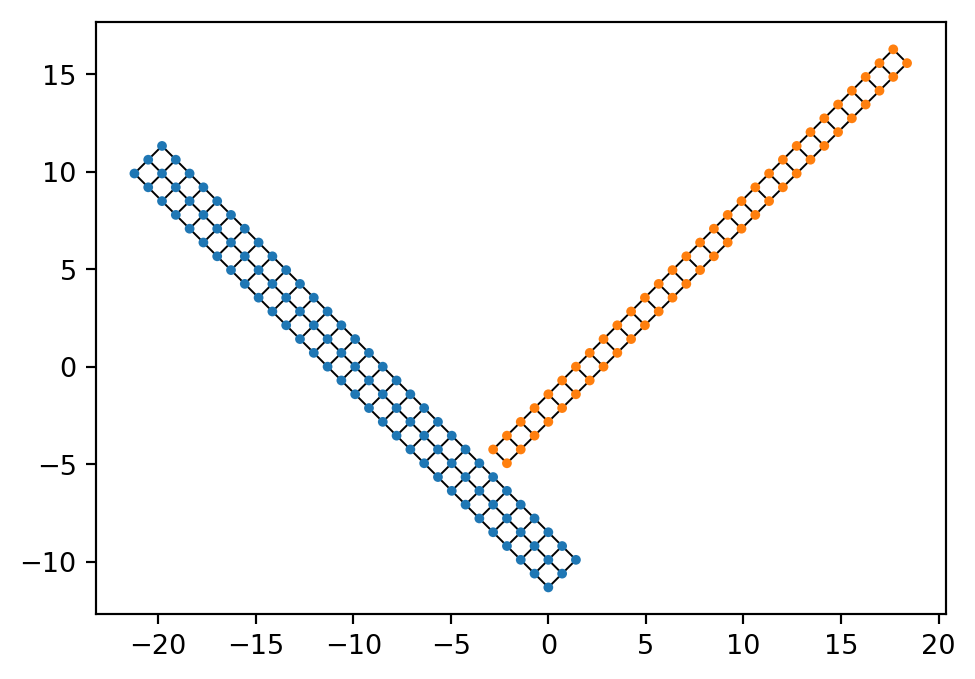

In [11]:
syst = kwant.Builder()

#syst = make_wire(syst, 2, 10, np.pi/6, np.array([5, 0]))
#syst = make_wire(syst, 2, 20, -np.pi/3, np.array([0, 0]))
syst = make_wire(syst, 1, 15, np.pi/4, np.array([8, 6]))
syst = make_wire(syst, 1, 15, np.pi/4 - np.pi/2, np.array([-10, 0]))



kwant.plot(syst, dpi=196);